# 대응 표본 T-검정 (Paired T-test)

표본의 각 사례마다 대응하는 2개의 관측치를 통해 판단

한 집단에 어떤 작용이 가해졌을 때에 대한 before, after를 비교

'related samples t-test' 또는 'paired samples t-test'로 부른다.

## #01. 준비작업

### [1] 패키지 참조

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import sys
import seaborn as sb
from math import sqrt
from pandas import read_excel, melt
from matplotlib import pyplot as plt
from scipy.stats import t, normaltest, bartlett, levene, ttest_rel, mannwhitneyu
from statannotations.Annotator import Annotator

### [2] 그래프 초기화

In [3]:
plt.rcParams['font.family']='AppleGothic' if sys.platform == 'darwin' else 'Malgun Gothic'
plt.rcParams['font.size']=12
plt.rcParams['figure.figsize']=(12,6)
plt.rcParams['axes.unicode_minus']=False

## #02. 예제 (1) - 사슴의 다리 길이 비교

사슴의 왼쪽 앞다리와 왼쪽 뒷다리의 길이를 측정한 자료를 통해 두 다리의 길이(cm)가 같은지 다른지 알고 싶다.

이 경우 한 사슴에 대하여 두 다리 길이를 측정하였으므로 사슴은 독립이지만 한 마리의 사슴의 일부인 두 다리는 독립이 아니다.

### [1] 데이터 가져오기

In [6]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/수업자료/deer.xlsx')
origin = origin.set_index('사슴')
origin

,앞다리,뒷다리
사슴,,
1,138,142
2,136,140
3,147,144
4,139,144
5,143,142
6,141,146
7,143,149
8,145,150
9,136,142


### [2] 신뢰구간 확인

두 변수의 데이터 분포와 신뢰구간을 확인한다.

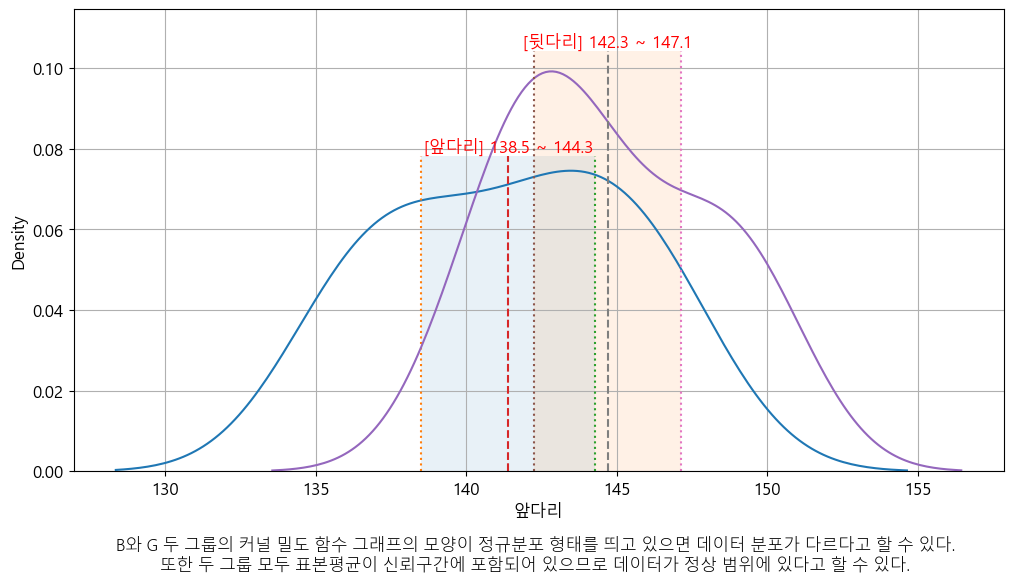

In [7]:
plt.figure()

for c in origin.columns:
    #print(c)

    data = origin[c]
    max = data.max()
    clevel=0.95
    dof=len(data)-1
    sample_mean = data.mean()
    sample_std = data.std(ddof=1)
    sample_std_error = sample_std / sqrt(len(data))

# 신뢰구간
    
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기

    plt.plot([cmin,cmin],[ymin,ymax],linestyle=':')
    plt.plot([cmax,cmax],[ymin,ymax],linestyle=':')
    plt.fill_between([cmin,cmax],y1=0,y2=ymax,alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean,sample_mean],[0,ymax],linestyle='--')

    plt.text(x=(cmax-cmin)/2+cmin,
             y=ymax,
             s='[%s] %0.1f ~ %0.1f' % (c,cmin,cmax),
             horizontalalignment='center',
             verticalalignment='bottom',
             fontdict={'size':12,'color':'red'})
    
plt.ylim(ymin,ymax*1.1)

txt = """B와 G 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포 형태를 띄고 있으면 데이터 분포가 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상 범위에 있다고 할 수 있다."""

plt.figtext(0.51,0,txt,wrap=True,
            verticalalignment='top', horizontalalignment='center',
            fontdict={'size':12,'weight':'light'})

plt.grid()
plt.show()
plt.close()



### [3] 가설검정의 가정 확인

#### (1) 정규성

In [8]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print('[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}'.format(c,s,p,p>0.05))
    

[앞다리] statistic: 1.824, p-value: 0.402, 정규성 충족 여부: True
[뒷다리] statistic: 1.377, p-value: 0.502, 정규성 충족 여부: True


#### (2) 등분산성

In [9]:
normal_dist = True
data = origin.copy()
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = 'bartlett'
    s, p = bartlett(*fields)

else:
    n = 'levene'
    s, p = levene(*fields)

print('{0}검정: statistic: {1:.3f}, p-value:{2:.3f}, 등분산성 충족 여부: {3}'.format(n,s,p,p > 0.05))

bartlett검정: statistic: 0.247, p-value:0.619, 등분산성 충족 여부: True


### [4] 사슴의 앞다리와 뒷다리의 길이가 다른지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 앞다리 | $\mu(앞다리)$ | |
| 뒷다리 | $\mu(뒷다리)$ | |
| 귀무가설($H_0$) | $\mu(앞다리) = \mu(뒷다리)$ | 사슴의 앞다리와 뒷다리 길이에는 차이가 없다 |
| 대립가설($H_1$) | $\mu(앞다리) \neq \mu(뒷다리)$ | 사슴의 앞다리와 뒷다리 길이에는 차이가 있다 |

두 그룹간의 평균을 비교하기 위해서는 `alternative` 파라미터를 `two-sided`로 설정해야 한다.

In [10]:
s, p = ttest_rel(origin['앞다리'],origin['뒷다리'], alternative='two-sided')
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: -3.414, p-value: 0.008, 대립가설 채택'

### [5] 앞다리가 뒷다리보다 더 긴지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \leq \mu(G)$ | 사슴의 앞다리는 뒷다리보다 길지 않다 |
| 대립가설($H_1$) | $\mu(B) > \mu(G)$ | 사슴의 앞다리는 뒷다리보다 길다 |

In [11]:
s, p = ttest_rel(origin['앞다리'],origin['뒷다리'], alternative='greater')
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: -3.414, p-value: 0.996, 귀무가설 채택'

### [6] 앞다리가 뒷다리보다 더 짧은지 검정

| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(B) \geq \mu(G)$ | 사슴의 앞다리는 뒷다리보다 짧지 않다 |
| 대립가설($H_1$) | $\mu(B) < \mu(G)$ | 사슴의 앞다리는 뒷다리보다 짧다 |

In [12]:
s, p = ttest_rel(origin['앞다리'],origin['뒷다리'], alternative='less')
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: -3.414, p-value: 0.004, 대립가설 채택'

### [7] 가설검정 시각화

In [13]:
df = melt(origin, var_name='group', value_name='value')
df

,group,value
0,앞다리,138
1,앞다리,136
2,앞다리,147
3,앞다리,139
4,앞다리,143
5,앞다리,141
6,앞다리,143
7,앞다리,145
8,앞다리,136
9,앞다리,146


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

앞다리 vs. 뒷다리: t-test paired samples, P_val:7.703e-03 t=-3.414e+00


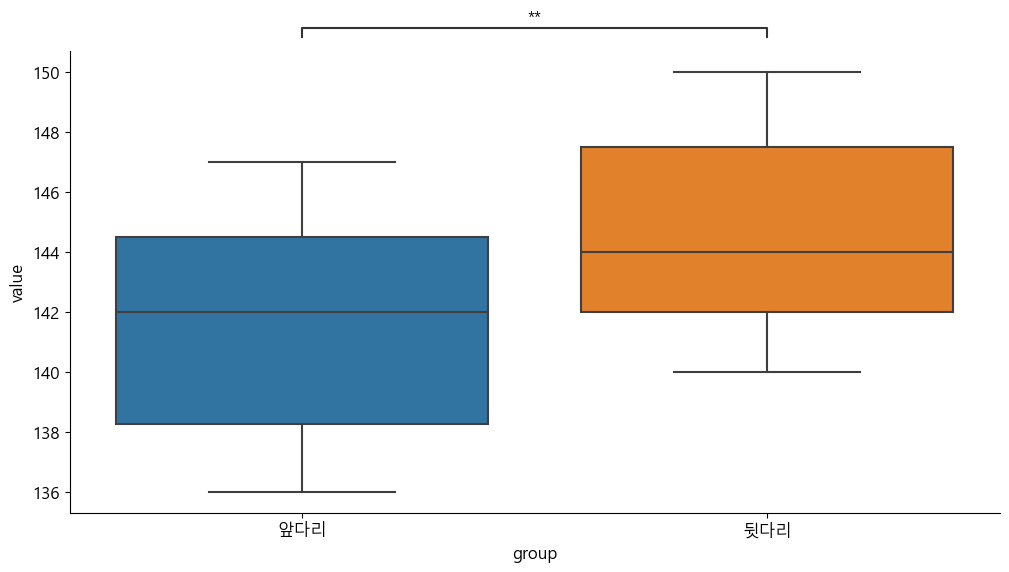

In [14]:
config = {
    'data': df,
    'x': 'group',
    'y': 'value',
    'pairs': [('앞다리','뒷다리')],
    'test':'t-test_paired',
    'text_format':'star',
    'loc':'outside'

}

plt.figure()
ax = sb.boxplot(data=config['data'],x=config['x'],y=config['y'])
ax.get_xaxis().axis_name

annotator = Annotator(ax, data=config['data'],x = config['x'], y = config['y'], pairs=config['pairs'])
annotator.configure(test=config['test'],text_format=config['text_format'],loc=config['loc'])
annotator.apply_and_annotate()

sb.despine()
plt.show()
plt.close()


## #03. 예제 (2) - 자동차 첨가제가 주행거리에 미치는 영향

다섯 종류의 새 차에 대하여 같은 종류의 차 두 대 중에서 한 대를 랜덤하게 선택하여 첨가제를 사용하고, 다른 한 대에는 첨가제를 사용하지 않고 같은 운전자가 같은 장소에서 운전한 결과 다음과 같은 자료를 얻었다.

첨가제를 사용하면 주행거리가 늘어난다고 할 수 있는지 유의수준 5%에서 검정하여 보라.

> 그룹A : 첨가제를 사용한 경우, 그룹B : 첨가제를 사용하지 않은 경우

### [1] 데이터 가져오기

In [15]:
origin = read_excel('C:/Users/Jihwan/01Class/E.추론통계/수업자료/oil.xlsx')
origin

,그룹A,그룹B
0,13.2,11.8
1,13.1,13.9
2,16.3,12.1
3,14.9,10.5
4,14.2,9.3
5,16.1,16.3
6,15.1,15.1
7,13.6,12.3
8,15.8,11.6
9,14.2,8.4


### [2] 신뢰구간 확인

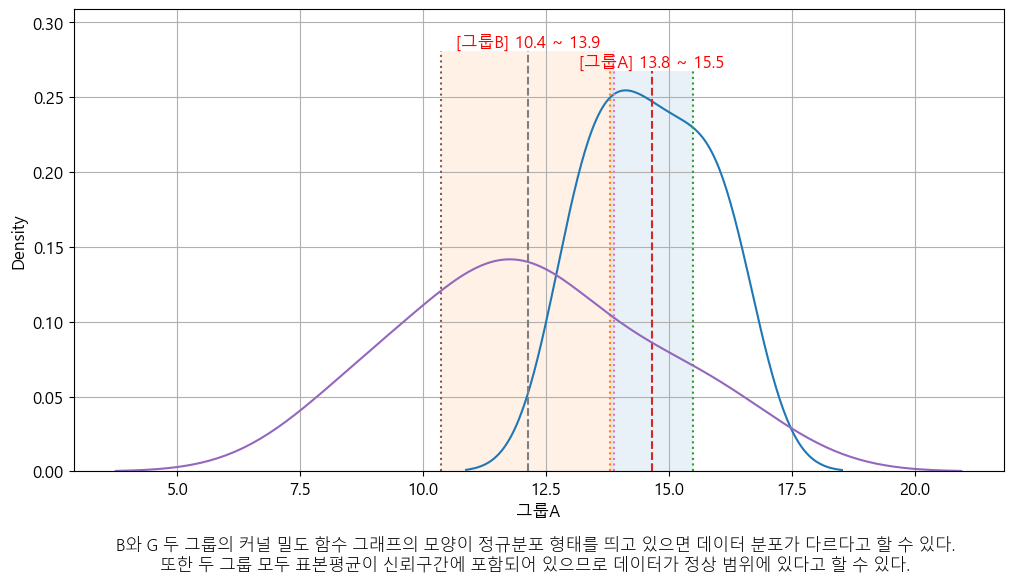

In [16]:
plt.figure()

for c in origin.columns:
    #print(c)

    data = origin[c]
    max = data.max()
    clevel=0.95
    dof=len(data)-1
    sample_mean = data.mean()
    sample_std = data.std(ddof=1)
    sample_std_error = sample_std / sqrt(len(data))

# 신뢰구간
    
    cmin, cmax = t.interval(clevel, dof, loc=sample_mean, scale=sample_std_error)

    sb.kdeplot(data=data)

    xmin, xmax, ymin, ymax = plt.axis()

    # 신뢰구간 그리기

    plt.plot([cmin,cmin],[ymin,ymax],linestyle=':')
    plt.plot([cmax,cmax],[ymin,ymax],linestyle=':')
    plt.fill_between([cmin,cmax],y1=0,y2=ymax,alpha=0.1)

    # 평균 그리기
    plt.plot([sample_mean,sample_mean],[0,ymax],linestyle='--')

    plt.text(x=(cmax-cmin)/2+cmin,
             y=ymax,
             s='[%s] %0.1f ~ %0.1f' % (c,cmin,cmax),
             horizontalalignment='center',
             verticalalignment='bottom',
             fontdict={'size':12,'color':'red'})
    
plt.ylim(ymin,ymax*1.1)

txt = """B와 G 두 그룹의 커널 밀도 함수 그래프의 모양이 정규분포 형태를 띄고 있으면 데이터 분포가 다르다고 할 수 있다.
또한 두 그룹 모두 표본평균이 신뢰구간에 포함되어 있으므로 데이터가 정상 범위에 있다고 할 수 있다."""

plt.figtext(0.51,0,txt,wrap=True,
            verticalalignment='top', horizontalalignment='center',
            fontdict={'size':12,'weight':'light'})

plt.grid()
plt.show()
plt.close()



### [3] 가설검정 가정 확인

#### (1) 정규성

In [17]:
for c in origin.columns:
    s, p = normaltest(origin[c])
    print('[{0}] statistic: {1:.3f}, p-value: {2:.3f}, 정규성 충족 여부: {3}'.format(c,s,p,p>0.05))
    

[그룹A] statistic: 1.804, p-value: 0.406, 정규성 충족 여부: True
[그룹B] statistic: 0.151, p-value: 0.927, 정규성 충족 여부: True


#### (2) 등분산성

In [18]:
normal_dist = True
data = origin.copy()
fields = list(map(lambda x: data[x], data.columns))

if normal_dist:
    n = 'bartlett'
    s, p = bartlett(*fields)

else:
    n = 'levene'
    s, p = levene(*fields)

print('{0}검정: statistic: {1:.3f}, p-value:{2:.3f}, 등분산성 충족 여부: {3}'.format(n,s,p,p > 0.05))

bartlett검정: statistic: 4.273, p-value:0.039, 등분산성 충족 여부: False


### [4] 두 그룹의 주행거리가 차이가 있는지 검정

데이터가 등분산성을 만족하지 않을 경우 `mannwhitneyu` 함수를 사용하여 `Mann–Whitney U 검정`을 시행한다.

| 구분 | 수식 | 내용 |
|---|---|---|
| 그룹A의 주행거리 평균 | $\mu(A)$ | |
| 그룹B의 주행거리 평균 | $\mu(B)$ | |
| 귀무가설($H_0$) | $\mu(A) = \mu(A)$ | 그룹A와 그룹B의 주행거리에는 차이가 없다.<br/>즉, 실험에 사용된 첨가제는 주행거리에 영향을 주지 않는다. |
| 대립가설($H_1$) | $\mu(B) \neq \mu(B)$ | 그룹A와 그룹B의 주행거리에는 차이가 있다.<br/>즉, 실험에 사용된 첨가제는 주행거리에 영향을 준다. |

In [19]:
s, p = mannwhitneyu(origin['그룹A'],origin['그룹B'], alternative='two-sided')
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: 81.000, p-value: 0.021, 대립가설 채택'

### [5] 그룹A의 주행거리가 그룹B의 주행거리보다 짧은지 검정


| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(A) \geq \mu(B)$ | 그룹A의 평균 주행거리는 그룹B의 평균 주행거리보다 짧지 않다. |
| 대립가설($H_1$) | $\mu(A) \lt \mu(B)$ | 그룹A의 평균 주행거리는 그룹B의 평균 주행거리보다 짧다. |

In [20]:
s, p = mannwhitneyu(origin['그룹A'],origin['그룹B'], alternative='less')
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: 81.000, p-value: 0.991, 귀무가설 채택'

### [6] 그룹A의 주행거리가 그룹B의 주행거리보다 긴지 검정


| 구분 | 수식 | 내용 |
|---|---|---|
| 귀무가설($H_0$) | $\mu(A) \leq \mu(B)$ | 그룹A의 주행거리는 그룹B의 주행거리보다 길지 않다. 첨가제는 주행거리를 늘리는데 효과가 없다. |
| 대립가설($H_1$) | $\mu(A) \gt \mu(B)$ | 그룹A의 주행거리는 그룹B의 주행거리보다 길다. 첨가제는 주행거리를 늘리는데 효과가 있다. |

In [21]:
s, p = mannwhitneyu(origin['그룹A'],origin['그룹B'], alternative='greater')
'statistic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택'.format(s,p,'대립' if p <= 0.05 else '귀무')

'statistic: 81.000, p-value: 0.010, 대립가설 채택'

### [7] 가설검정 시각화

In [22]:
df = melt(origin,var_name='group',value_name='value')
df

,group,value
0,그룹A,13.2
1,그룹A,13.1
2,그룹A,16.3
3,그룹A,14.9
4,그룹A,14.2
5,그룹A,16.1
6,그룹A,15.1
7,그룹A,13.6
8,그룹A,15.8
9,그룹A,14.2


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test two-sided, P_val:2.099e-02 U_stat=8.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test smaller, P_val:9.914e-01 U_stat=8.100e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

그룹A vs. 그룹B: Mann-Whitney-Wilcoxon test greater, P_val:1.049e-02 U_stat=8.100e+01


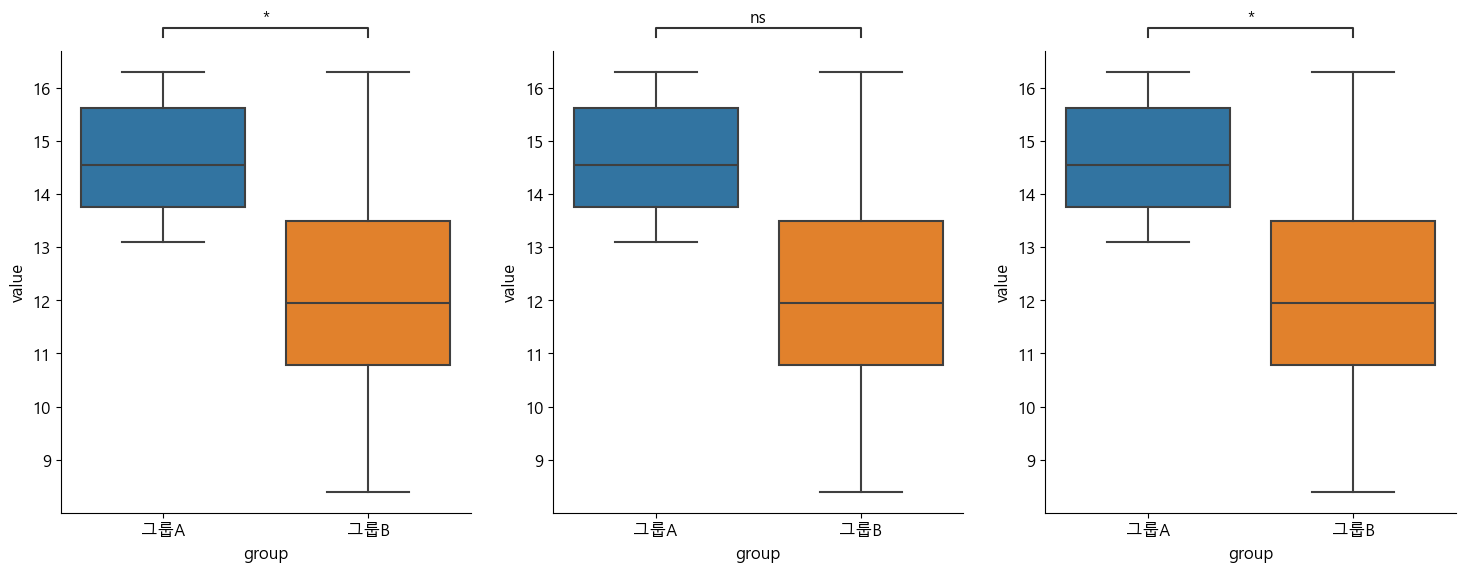

In [23]:
test = ['Mann-Whitney', 'Mann-Whitney-ls', 'Mann-Whitney-gt']

config = {
    'data': df,
    'x': 'group',
    'y': 'value',
    'pairs': [('그룹A','그룹B')],
    'test': None,
    'text_format':'star',
    'loc':'outside'
}

fig, ax = plt.subplots(1,3,figsize=(18,6))

for i, v in enumerate(ax):
    config['test'] = test[i]

    k = sb.boxplot(ax=v, data=config['data'], x=config['x'], y=config['y'])
    v.get_xaxis().axis_name 

    annotator = Annotator(k, data=config['data'],x = config['x'], y = config['y'], pairs=config['pairs'])
    annotator.configure(test=config['test'],text_format=config['text_format'],loc=config['loc'])
    annotator.apply_and_annotate()

    sb.despine(ax=v)
plt.show()
plt.close()
